In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/UTKFace.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
import os
import shutil

# Chemin vers le dossier UTKFace
utkface_folder = "/content/UTKFace"

# Créer un dossier de sortie
output_folder = "/content/UTKFaceN"
os.makedirs(output_folder, exist_ok=True)

# Définir les âges pour lesquels vous voulez collecter des images
ages_to_collect = list(range(1, 101))

# Nombre d'images à collecter par âge
images_per_age = 45

# Parcourir tous les fichiers dans le dossier UTKFace
for filename in os.listdir(utkface_folder):
    # Extraire l'âge du nom de fichier
    age = int(filename.split('_')[0])

    # Vérifier si l'âge est dans la liste des âges à collecter
    if age in ages_to_collect:
        # Copier le fichier dans le dossier UTKFaceM
        source_path = os.path.join(utkface_folder, filename)
        destination_path = os.path.join(output_folder, filename)
        shutil.copyfile(source_path, destination_path)

        # Décrémenter le nombre d'images à collecter pour cet âge
        images_per_age -= 1

        # Vérifier si vous avez collecté suffisamment d'images pour cet âge
        if images_per_age == 0:
            ages_to_collect.remove(age)
            images_per_age = 40  # Réinitialiser le nombre d'images à collecter pour le prochain âge

        if not ages_to_collect:
            break


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Fonction de défloutage
def deblur_image(image):
    # Appliquer un filtre de déconvolution (inverse du filtre de flou gaussien)
    kernel = np.ones((5, 5), np.float32) / 25
    deblurred_image = cv2.filter2D(image, -1, kernel)
    return deblurred_image

# 1. Explorer la structure du jeu de données
data_path = "/content/UTKFaceN"
images = []
labels = []

for filename in os.listdir(data_path):
    if filename.endswith(".jpg"):
        # Les noms de fichiers dans UTKFace sont formatés comme "âge_genre_date_heure_minute_seconde.jpg"
        age = int(filename.split('_')[0])
        labels.append(age)
        img_path = os.path.join(data_path, filename)
        img = cv2.imread(img_path)
        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        # Ajout de prétraitements pour réduire le bruit
        img = cv2.resize(img, (224, 224))  # Redimensionner les images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir l'image en format RGB
        img = deblur_image(img)  # Appliquer le défloutage

        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        images.append(img)

# Convertir les listes en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# 2. Diviser le jeu de données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Normaliser les images (mise à l'échelle des pixels entre 0 et 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Charger le modèle VGG16 pré-entraîné (poids ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées pour la prédiction de l'âge
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='linear')(x)  # Activation linéaire pour la prédiction de l'âge

# Créer le modèle complet
model = models.Model(inputs=base_model.input, outputs=output)

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Afficher un résumé du modèle
print(model.summary())


58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

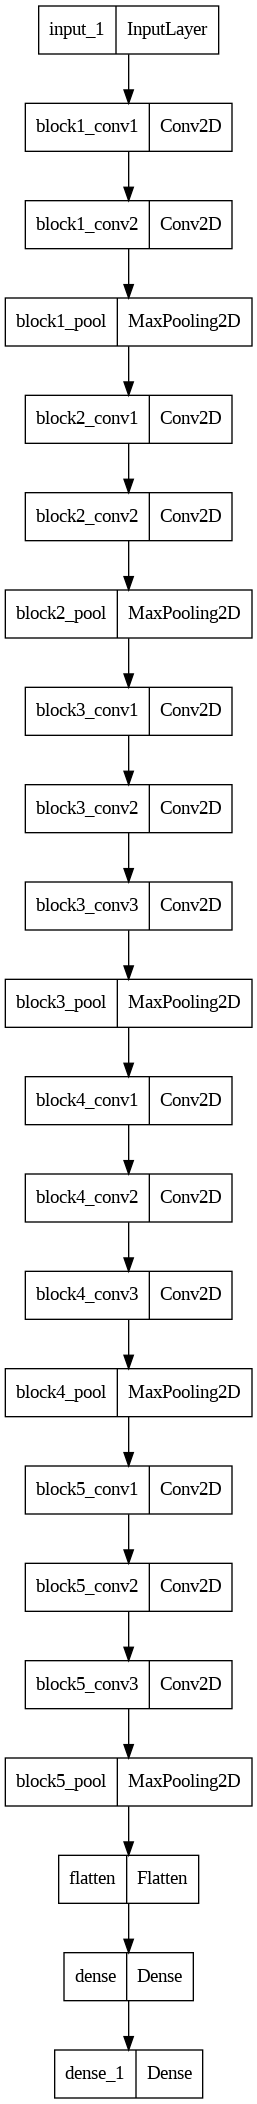

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=70)

Epoch 1/70
72/72 [==============================] - 26s 217ms/step - loss: 446.4691 - mae: 16.7945 - val_loss: 264.8416 - val_mae: 12.7170
Epoch 2/70
72/72 [==============================] - 11s 160ms/step - loss: 227.9565 - mae: 11.8530 - val_loss: 226.9047 - val_mae: 11.4820
Epoch 3/70
72/72 [==============================] - 12s 162ms/step - loss: 176.9105 - mae: 10.2617 - val_loss: 212.5189 - val_mae: 11.2062
Epoch 4/70
72/72 [==============================] - 11s 155ms/step - loss: 145.0998 - mae: 9.2082 - val_loss: 195.9674 - val_mae: 10.5368
Epoch 5/70
72/72 [==============================] - 12s 167ms/step - loss: 134.6047 - mae: 8.8387 - val_loss: 197.1932 - val_mae: 10.8344
Epoch 6/70
72/72 [==============================] - 12s 168ms/step - loss: 130.0253 - mae: 8.7724 - val_loss: 209.1523 - val_mae: 10.5996
Epoch 7/70
72/72 [==============================] - 12s 163ms/step - loss: 108.3488 - mae: 7.9114 - val_loss: 189.7210 - val_mae: 10.2584
Epoch 8/70
72/72 [=============

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

16/16 [==============================] - 2s 126ms/step - loss: 188.6432 - mae: 10.0510
Test Loss: 188.64320373535156, Test MAE: 10.051031112670898


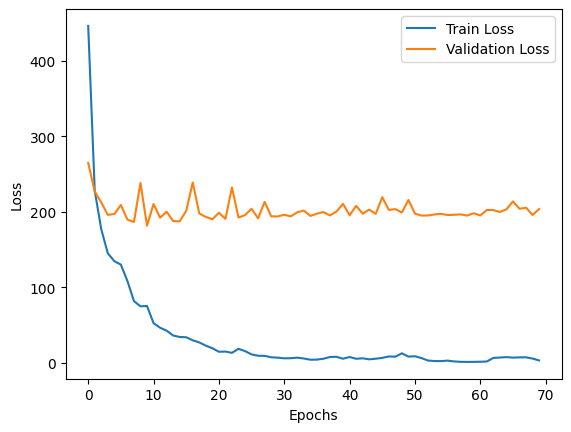

In [ ]:
import matplotlib.pyplot as plt

# Afficher les courbes d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
# Afficher les vrais âges et les prédictions sous forme de tableau
comparison_table = np.column_stack((y_test, predictions.flatten()))
print("Vrais Âges vs Prédictions d'Âge :\n", comparison_table)

16/16 [==============================] - 2s 131ms/step
Vrais Âges vs Prédictions d'Âge :
 [[ 3.40000000e+01  3.31643906e+01]
 [ 5.20000000e+01  6.67519531e+01]
 [ 5.80000000e+01  6.21862259e+01]
 [ 2.70000000e+01  4.25602188e+01]
 [ 4.00000000e+01  3.86187630e+01]
 [ 1.30000000e+01  7.43743181e+00]
 [ 6.40000000e+01  5.20920753e+01]
 [ 7.20000000e+01  7.48065567e+01]
 [ 3.10000000e+01  2.45490723e+01]
 [ 8.40000000e+01  5.68309860e+01]
 [ 6.00000000e+01  7.91246338e+01]
 [ 5.20000000e+01  5.10110283e+01]
 [ 6.00000000e+00  9.80651474e+00]
 [ 5.40000000e+01  3.42391357e+01]
 [ 3.30000000e+01  4.15195007e+01]
 [ 9.30000000e+01  5.46420403e+01]
 [ 4.80000000e+01  3.26060104e+01]
 [ 1.50000000e+01  4.14370689e+01]
 [ 7.00000000e+00  5.35588264e+00]
 [ 2.50000000e+01  2.24488697e+01]
 [ 4.00000000e+00  7.79863167e+00]
 [ 3.20000000e+01  1.63471527e+01]
 [ 1.20000000e+01  1.58848495e+01]
 [ 5.20000000e+01  3.08113022e+01]
 [ 5.90000000e+01  2.67843590e+01]
 [ 5.30000000e+01  5.75795212e+01]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcul des métriques
mae = mean_absolute_error(y_test, predictions.flatten())
mse = mean_squared_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions.flatten())

# Affichage des résultats
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

MAE: 10.05
MSE: 188.64
RMSE: 13.73
R^2: 0.73


In [ ]:
tolerance = 10  # La fourchette acceptable autour de l'âge réel

# Calculer la précision
correct_predictions = np.sum(np.abs(y_test - predictions.flatten()) <= tolerance)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

# Afficher la précision
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 60.25%
